<a href="https://colab.research.google.com/github/jayshah1819/CUDA_PREP/blob/main/CUDA_Julia_Set_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
code = '''#include <iostream>
#include <opencv2/opencv.hpp>
#include <cuda_runtime.h>

#define DIM 1024
#define SCALE 1.5f
#define C_RE -0.7f
#define C_IM 0.27015f
#define MAX_ITER 1000

__global__ void julia_kernel(unsigned char* image) {
    int x = threadIdx.x + blockIdx.x * blockDim.x;
    int y = threadIdx.y + blockIdx.y * blockDim.y;

    if (x >= DIM || y >= DIM) return;

    float a = SCALE * (float)(x - DIM/2) / (DIM/2);
    float b = SCALE * (float)(y - DIM/2) / (DIM/2);

    float z_re = a;
    float z_im = b;
    int iter = 0;

    for (iter = 0; iter < MAX_ITER; iter++) {
        if (z_re * z_re + z_im * z_im >= 4.0f) {
            break;
        }

        float new_re = z_re * z_re - z_im * z_im + C_RE;
        float new_im = 2.0f * z_re * z_im + C_IM;

        z_re = new_re;
        z_im = new_im;
    }

    int idx = y * DIM + x;
    image[idx] = (iter == MAX_ITER) ? 0 : 255;
}

int main() {
    // Device info
    cudaDeviceProp prop;
    cudaGetDeviceProperties(&prop, 0);
    printf("GPU: %s (Compute %d.%d)\\n", prop.name, prop.major, prop.minor);

    unsigned char* d_image;
    int size = DIM * DIM * sizeof(unsigned char);

    cudaMalloc(&d_image, size);

    dim3 block(16, 16);
    dim3 grid((DIM + 15) / 16, (DIM + 15) / 16);

    julia_kernel<<<grid, block>>>(d_image);

    cudaError_t err = cudaGetLastError();
    if (err != cudaSuccess) {
        printf("Kernel error: %s\\n", cudaGetErrorString(err));
        return -1;
    }

    cudaDeviceSynchronize();

    unsigned char* h_image = new unsigned char[DIM * DIM];
    cudaMemcpy(h_image, d_image, size, cudaMemcpyDeviceToHost);

    cv::Mat result(DIM, DIM, CV_8UC1, h_image);
    cv::imwrite("julia.png", result);

    printf("Julia set saved as julia.png\\n");

    delete[] h_image;
    cudaFree(d_image);

    return 0;
}'''

with open('julia.cu', 'w') as f:
    f.write(code)
print("CUDA file created!")

CUDA file created!


In [6]:
!nvcc -o julia_set julia_set.cu `pkg-config --cflags --libs opencv4`


/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [7]:
# This is the EXACT command for Tesla T4
!nvcc -arch=sm_75 -o julia julia.cu `pkg-config --cflags --libs opencv4`


/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [8]:
!./julia

GPU: Tesla T4 (Compute 7.5)
Julia set saved as julia.png


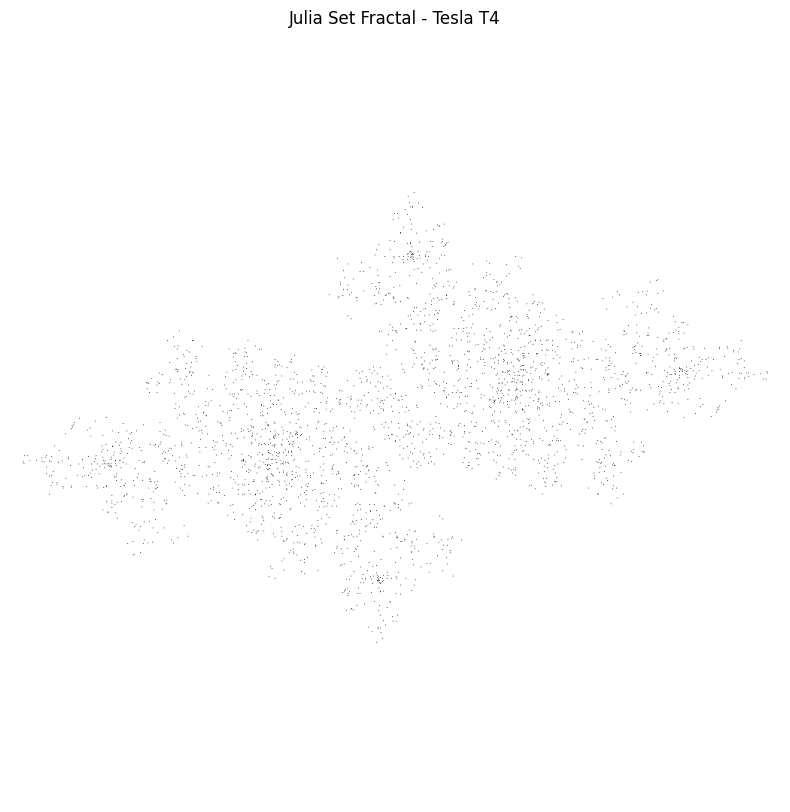

In [9]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('julia.png', 0)
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
plt.title('Julia Set Fractal - Tesla T4')
plt.axis('off')
plt.show()

In [4]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Tue Jul 29 22:18:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8       